In [17]:
import xarray as xr
import ACTEA_downscale
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

plt.style.use("default")

cmip6 = ACTEA_downscale.ACTEA_downscale()
var_name = "thetao"

sfc = "../Stratification_dataset/timeseries_surface_thetao_depth_5m_720x4320.nc"
btm = "../Stratification_dataset/timeseries_surface_thetao_depth_200m_720x4320.nc"

sfc_ds = xr.open_dataset(sfc)
btm_ds = xr.open_dataset(btm)

glorys_sfc_clim = cmip6.calculate_detrended_climatology(
    sfc_ds[var_name], var_name, description="sfc_climatology"
)

glorys_btm_clim = cmip6.calculate_detrended_climatology(
    btm_ds[var_name], var_name, description="btm_climatology"
)

glorys_sfc_clim.to_netcdf("../Stratification_dataset/clim_sfc.nc")
glorys_btm_clim.to_netcdf("../Stratification_dataset/clim_btm.nc")
sfc_ds.close()
btm_ds.close()

INFO:root:[ACTEA_downscale] Running calculation of climatology
INFO:root:[ACTEA_downscale] Average before de-trending sfc_climatology: 21.350
INFO:root:[ACTEA_downscale] Average after de-trending sfc_climatology: 21.340722400491686
INFO:root:[ACTEA_downscale] Running calculation of climatology
INFO:root:[ACTEA_downscale] Average before de-trending btm_climatology: 13.213
INFO:root:[ACTEA_downscale] Average after de-trending btm_climatology: 13.206605287801748


In [26]:
def plot_monthly_climatology(climatology):
    months = [
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ]
    lev = np.arange(-3, 18, 1)
    seasons = ["DJF", "MAM", "JJA", "SON"]
    seasons_indexes = [[11, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]
    for season, indexes in zip(seasons, seasons_indexes):
        fig = plt.figure(figsize=(12, 12))

        ax = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=-180))

        xticks = np.arange(-180, 180, 30)
        yticks = np.arange(0, 60, 10)

        ax.set_xticks(xticks, crs=ccrs.PlateCarree())
        ax.set_yticks(yticks, crs=ccrs.PlateCarree())
        #   lon_formatter = LongitudeFormatter(zero_direction_label=True)
        #   lat_formatter = LatitudeFormatter()
        #   ax.xaxis.set_major_formatter(lon_formatter)
        #   ax.yaxis.set_major_formatter(lat_formatter)
        #  ax.set_extent([-180, 180, np.min(climatology.lat), np.max(climatology.lat)])

        clim = np.nanmean(climatology[indexes], axis=0)

        cs = ax.contourf(
            climatology.lon.values,
            climatology.lat.values,
            clim,
            transform=ccrs.PlateCarree(central_longitude=0),
            levels=lev,
            cmap=sns.color_palette("Spectral_r", as_cmap=True),
            zorder=2,
            alpha=1.0,
            extend="both",
        )
        rivers_50m = cfeature.NaturalEarthFeature(
            "physical", "rivers_lake_centerlines", "50m"
        )

        ax.coastlines(
            resolution="10m",
            linewidth=0.1,
            facecolor="grey",
            color="black",
            alpha=0.8,
            zorder=0,
        )
        ax.add_feature(
            cfeature.LAND, facecolor="lightgrey", edgecolor="black", linewidth=0.1
        )
        ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.1)

        #   ax.add_feature(rivers_50m, facecolor='None', edgecolor='blue', linestyle=':')
        lev_list = lev.tolist()
        ticks = [
            float("{:.1f}".format(lev_list[i])) for i in range(0, len(lev_list), 2)
        ]
        do_bars = False
        if do_bars is True:
            clb = plt.colorbar(cs, fraction=0.03, orientation="horizontal", ticks=ticks)

            clb.ax.set_title("$^{o}$C", fontsize=10)
        #        plt.title(season)

        plt.tight_layout(h_pad=1)

        plt.savefig(
            "../Stratification_dataset/Figures/stratification_{}_wbars".format(season),
            bbox_inches="tight",
            pad_inches=0.1,
            dpi=300,
        )

        plt.show()

<ipython-input-26-4c9f8dfcd194>:35: RuntimeWarning: Mean of empty slice
  clim = np.nanmean(climatology[indexes], axis=0)


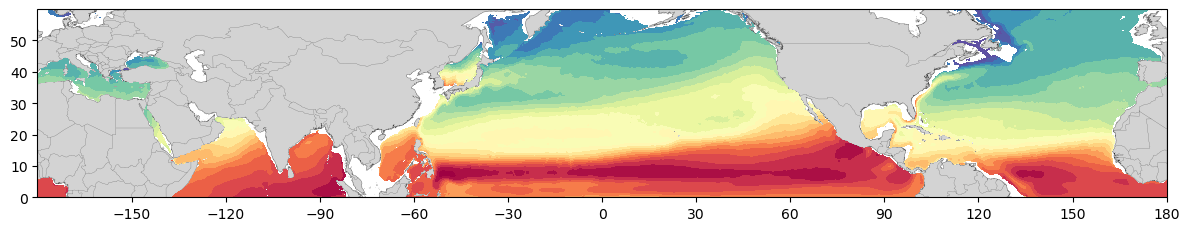

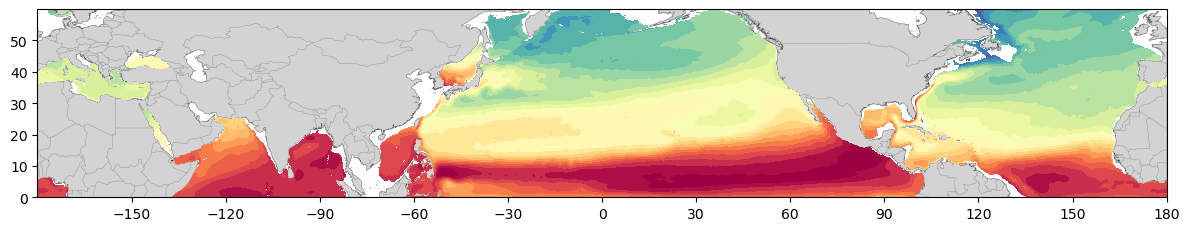

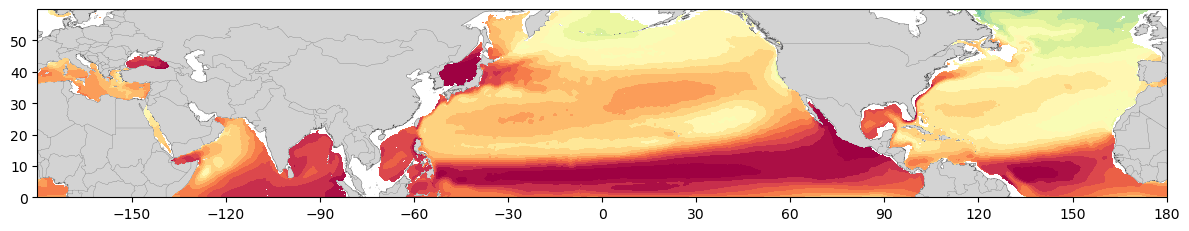

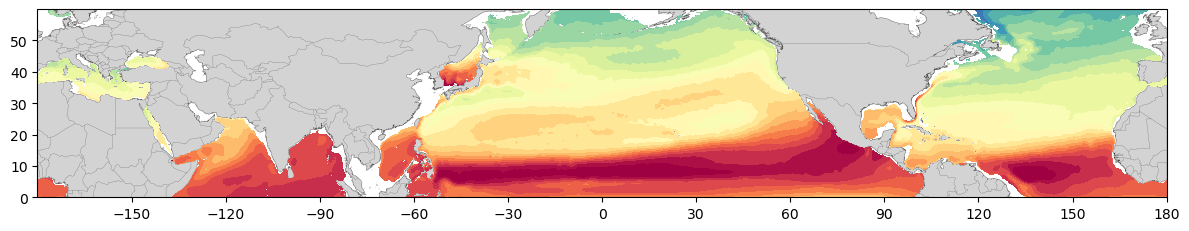

In [27]:
stratification = glorys_sfc_clim[var_name] - glorys_btm_clim[var_name]
stratification.to_netcdf("../Stratification_dataset/stratification.nc")
stratification_sorted = (
    stratification.assign_coords(lon=(np.mod(stratification.lon + 180, 360) - 180))
).sortby("lon")

plot_monthly_climatology(stratification_sorted)